In [1]:
import h5py

In [437]:
import torch
from torch.nn import functional as F

In [3]:
import flow_vis
import numpy as np

from matplotlib import pyplot as plt

In [764]:
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd

In [743]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [1019]:
name = '255027795_2652471757_o'
# name = '17450068_dc7884b082_o'
# name = '562094050_5938f37ea5_o'

torch.Size([1, 3, 800, 800])


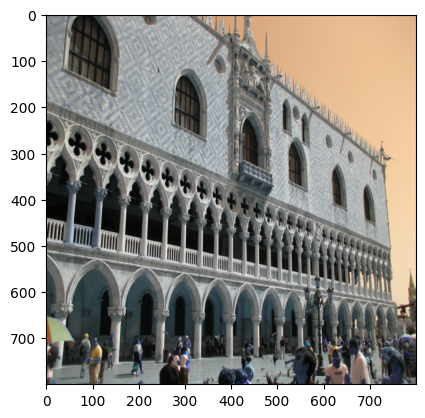

In [1020]:
conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

size = (800,800)

conf_homography = {
    'translation': True,
    'rotation': True,
    'scaling': True,
    'perspective': True,
    'scaling_amplitude': 0.2,
    'perspective_amplitude_x': 0.2,
    'perspective_amplitude_y': 0.2,
    'patch_ratio': 0.85,
    'max_angle': 1.57,
    'allow_artifacts': True
}
resize_func = Resize(size)
image_path = f"../SOLD2/experiments/{name}.jpg"
img = cv2.resize(cv2.imread(image_path),size)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)

print(img_torch.shape)
plt.imshow(img)
plt.show()

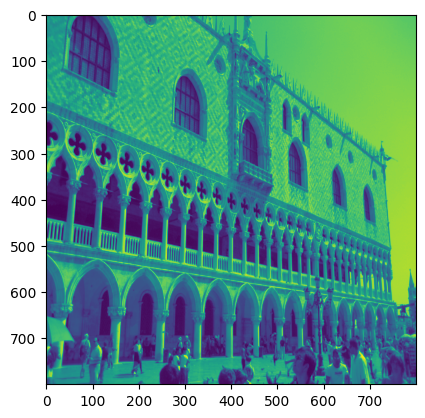

In [1021]:
scale = img_torch.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
gs_image = (img_torch * scale).sum(1, keepdim=True)
np_gs_image = gs_image.squeeze().numpy()
plt.imshow(np_gs_image)

In [1022]:
f = h5py.File(f'./experiments/{name}.hdf5', 'r')

In [1023]:
list(f.keys())

['deeplsd_angle_field', 'deeplsd_distance_field']

In [1024]:
angle_field = f['deeplsd_angle_field']
angle_field.shape

(800, 800)

In [1025]:
distance_field = f['deeplsd_distance_field']
distance_field.shape

(800, 800)

In [1026]:
npaf = angle_field[()]
npaf

array([[0.41245505, 0.55248684, 0.6672938 , ..., 0.61001635, 0.6202425 ,
        0.64679193],
       [0.82380223, 0.7378143 , 0.74149466, ..., 0.60884404, 0.63759506,
        0.7149692 ],
       [0.7706529 , 0.7253728 , 0.7254653 , ..., 0.9420517 , 0.6103165 ,
        0.69536555],
       ...,
       [1.7635984 , 1.8430321 , 1.4890672 , ..., 1.1784074 , 1.2189906 ,
        1.2315004 ],
       [1.7930567 , 1.7816733 , 1.7282953 , ..., 1.1401833 , 1.1925228 ,
        1.2651626 ],
       [1.9056782 , 1.757192  , 1.6895472 , ..., 1.0139632 , 1.0508629 ,
        1.1567923 ]], dtype=float32)

In [1027]:
npdf = distance_field[()]
npdf

array([[3.1744237, 3.1700847, 3.4676259, ..., 2.2739246, 2.2000952,
        2.2273138],
       [3.0779865, 3.0440435, 3.4088063, ..., 2.1970272, 2.0745726,
        2.2584376],
       [3.2688997, 3.176022 , 3.1213586, ..., 3.3022826, 2.5678303,
        2.4840178],
       ...,
       [3.5520763, 4.044631 , 4.067432 , ..., 1.548753 , 2.6968648,
        2.855907 ],
       [3.3686142, 3.6365604, 3.6535192, ..., 2.3546224, 2.365856 ,
        2.6133263],
       [3.1465888, 3.3028407, 3.4887278, ..., 2.4878092, 2.3465006,
        2.5856605]], dtype=float32)

In [1028]:
f.close()

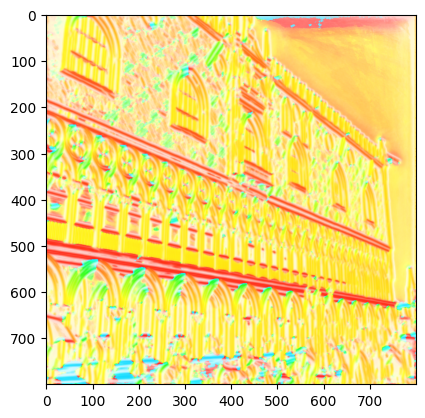

In [1029]:
plt.imshow(get_flow_vis(npdf, npaf))
plt.show()

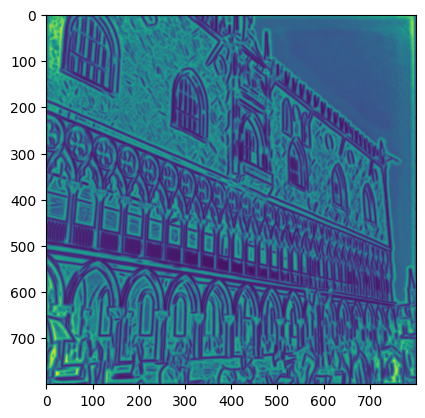

In [1030]:
plt.imshow(npdf)
plt.show()

In [1031]:
f = h5py.File(f'./experiments/sp_{name}.hdf5', 'r')

In [1032]:
list(f.keys())

['superpoint_heatmap']

In [1033]:
superpoint_heatmap = f['superpoint_heatmap']
superpoint_heatmap.shape

(800, 800)

In [1034]:
sphm = superpoint_heatmap[()]

In [1035]:
f.close()

In [1036]:
sphm = np.nan_to_num(sphm, nan=0)

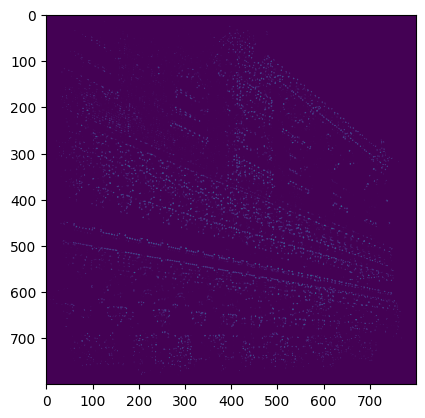

In [1037]:
plt.imshow(sphm)
plt.show()

In [1038]:
def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


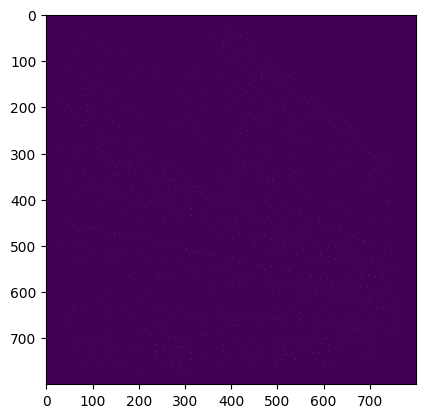

In [1089]:
nms_sphm = batched_nms(torch.Tensor(sphm).unsqueeze(0), 10).squeeze()
plt.imshow(nms_sphm)
plt.show()

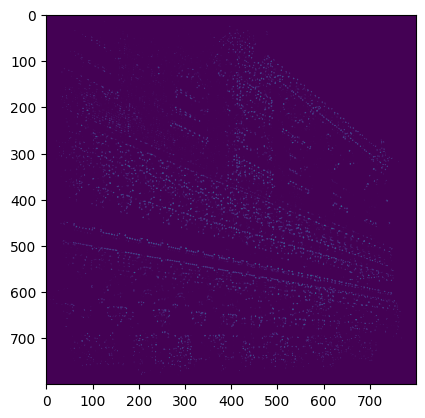

In [1090]:
nsphm = sphm / sphm.max()

plt.imshow(nsphm)
plt.show()

In [1091]:
nms_sphm.max()

tensor(0.6876)

In [1092]:
DF_THRESH = 3

In [1093]:
valid_sphm = nms_sphm.clone()
valid_sphm[df > DF_THRESH] = 0

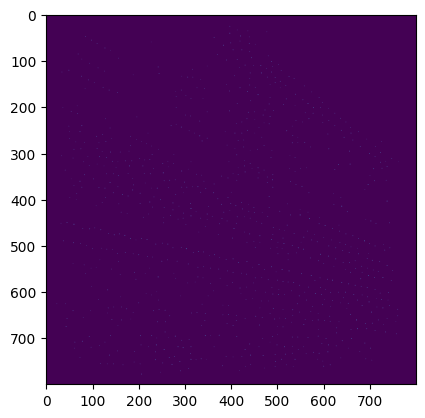

In [1094]:
thresh = 0.2
sup_sphm = valid_sphm / valid_sphm.max()
sup_sphm[sup_sphm < thresh] = 0

plt.imshow(sup_sphm)
plt.show()

In [1095]:
kpx, kpy = sup_sphm.nonzero().T
kpx.shape

torch.Size([879])

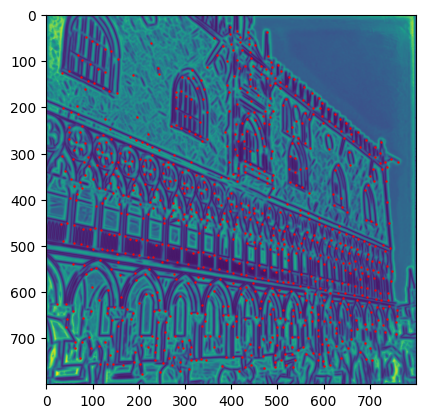

In [1096]:
plt.imshow(npdf)
plt.scatter(kpy, kpx, c='r', s=0.5)
plt.show()

In [1097]:
junctions = np.array([kpx, kpy]).T
junctions = np.array(sorted(junctions, key=lambda x: x.sum()))
junctions.shape

(879, 2)

In [1098]:
from sold2.model.line_detection import LineSegmentDetectionModule

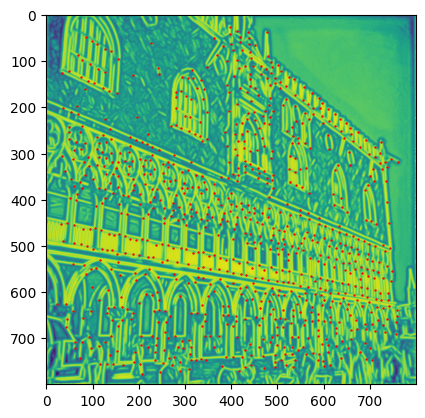

In [1099]:
negnpdf = 1 - npdf / npdf.max()

plt.imshow(negnpdf)
plt.scatter(kpy, kpx, c='r', s=0.5)
plt.show()

In [1100]:
(npdf / npdf.max()).mean()

0.33494294

In [1101]:
# detector = LineSegmentDetectionModule(0.8, heatmap_low_thresh=0.5, heatmap_high_thresh=0.7)

In [1102]:
# det_out = detector.detect(nsphm, negnpdf)
# det_out

In [1103]:
# plt.imshow(det_out[0])
# plt.show()

points.mean() 3.9352288
direction 1.6307244819141116
inlier_ratio 1.0
angles.std() 0.05588894
angles.mean() 1.6378489
True True True True


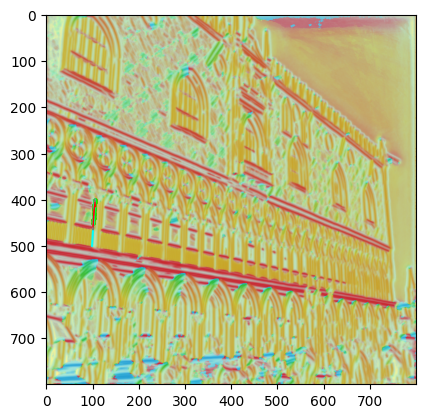

True

In [1105]:
def is_there_a_line_between(
    # lines, df,
    x1, y1, x2, y2, df, 
                            n_samples=10, df_thresh=5, inlier_thresh=0.7, dist_thresh=50, 
                            r_ratio=0.1, a_diff_thresh=np.pi/20, a_std_thresh=np.pi/30,
    r_radius=5,
    check_sample=False,
):
    # l = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    # if l > dist_thresh:
    #     return False
    if x1 == x2 and y1 == y2:
        return False

    # xs = np.random.randint(x1, x2 + 1, size=sample_n)
    # ys = np.random.randint(y1, y2 + 1, size=sample_n)
    # sample_n = max(min(n_samples, (x2 - x1), (y2 - y1)), 1)
    xint = np.abs(x2 - x1) / (n_samples + 1)
    yint = np.abs(y2 - y1) / (n_samples + 1)

    xs = np.linspace(x1, x2, n_samples)
    ys = np.linspace(y1, y2, n_samples)
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    # r = int(l * r_ratio)
    r = int(r_ratio)
    xid, yid = np.mgrid[0:df.shape[0], 0:df.shape[1]]
    
    point_indices = np.array([df[max(xs[i]-r, 0):xs[i]+r+1, max(ys[i]-r, 0):ys[i]+r+1].argmin() for i in range(len(xs))])
    valid_xs = (xs + (point_indices / (r * 2 + 1) - r)).astype(int)
    valid_ys = (ys + (point_indices % (r * 2 + 1) - r)).astype(int)
    points = df[valid_xs, valid_ys]
    angles = npaf[valid_xs, valid_ys]

    xs, ys = valid_xs, valid_ys

    x1 = valid_xs[0]
    y1 = valid_ys[0]
    x2 = valid_xs[-1]
    y2 = valid_ys[-1]

    # direction = (np.arctan((y2 - y1) / (x2 - x1 + 1e-10)) + np.pi / 2)
    direction = np.mod(np.arctan((x2 - x1) / (y2 - y1 + 1e-10)), np.pi)

    # pred_grad = np.mod(angle, np.pi)  # in [0, pi]
    # pos_dist = np.minimum(np.abs(img_grad_angle - pred_grad),
    #                       2 * np.pi - np.abs(img_grad_angle - pred_grad))
    # neg_dist = np.minimum(
    #     np.abs(img_grad_angle - pred_grad + np.pi),
    #     2 * np.pi - np.abs(img_grad_angle - pred_grad + np.pi))
    
    # # Assign the new grad angle to the closest of the two
    # is_pos_closest = np.argmin(np.stack([neg_dist, pos_dist],
    #                                     axis=-1), axis=-1).astype(bool)
    # new_grad_angle = np.where(is_pos_closest, pred_grad, pred_grad - np.pi)

    inlier_indices = points < df_thresh

    inlier_ratio = (inlier_indices).sum() / len(xs)
    valid_angles = angles[inlier_indices]

    crit1 = points.mean() < df_thresh
    crit2 = valid_angles.std() < a_std_thresh
    crit3 = inlier_ratio > inlier_thresh
    crit4 = np.mod(valid_angles.mean() - direction, np.pi) < a_diff_thresh

    if check_sample:
        print("points.mean()", points.mean())
        print("direction", direction)
        print("inlier_ratio", inlier_ratio)
        print("angles.std()", angles.std())
        print("angles.mean()", angles.mean())
        print(crit1, crit2, crit3, crit4)
        plt.imshow(get_flow_vis(df, npaf))
        plt.imshow(df, alpha=0.3)

        ny = y1 + np.cos(direction) * 100
        nx = x1 + np.sin(direction) * 100
        plt.plot([y1, ny], [x1, nx], c='cyan')

        for x, y, a in zip(xs, ys, angles):
            ny = y + np.cos(a) * 15
            nx = x + np.sin(a) * 15
            plt.plot([y, ny], [x, nx], c='red', linewidth=0.75)
        
        plt.scatter(ys, xs, c='r', s=5)
        plt.scatter(valid_ys, valid_xs, c='lime', s=5)
        
        plt.show()
        # fig, ax = plt.subplots(nrows=2, ncols=2)
        # ax[0][0].imshow(crit1)
        # ax[0][1].imshow(crit2)
        # ax[1][0].imshow(crit3)
        # ax[1][1].imshow(crit4)
        # plt.show()

    return (
        crit1 & 
        crit2 & 
        crit3 & 
        crit4
    )
    # return df_check & ang_check

is_there_a_line_between(400, 105, 450, 102, npdf, dist_thresh=200, check_sample=True)

In [1106]:
junctions.shape

(879, 2)

In [1107]:
junctions_t = torch.Tensor(junctions)
main_lines = torch.hstack([
    torch.cartesian_prod(junctions_t[:, 0], junctions_t[:, 0]),
    torch.cartesian_prod(junctions_t[:, 1], junctions_t[:, 1]),
]).reshape((-1, 2, 2))
main_lines

tensor([[[ 48.,  48.],
         [ 85.,  85.]],

        [[ 48.,  56.],
         [ 85.,  98.]],

        [[ 48.,  86.],
         [ 85.,  69.]],

        ...,

        [[748., 745.],
         [704., 691.]],

        [[748., 691.],
         [704., 757.]],

        [[748., 748.],
         [704., 704.]]])

In [1108]:
main_lines.shape

torch.Size([772641, 2, 2])

In [1110]:
max_dist_thresh = 50
lines = main_lines[((main_lines[:, 0, 1] - main_lines[:, 0, 0])**2 + (main_lines[:, 1, 1] - main_lines[:, 1, 0])**2) < max_dist_thresh ** 2]
lines.shape

torch.Size([14047, 2, 2])

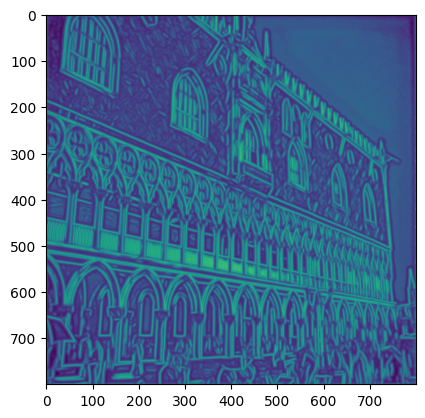

In [1111]:
line_neighborhood = 5

def normalize_df(df):
    return -np.log(df / line_neighborhood + 1e-6)

def denormalize_df(df_norm):
    return np.exp(-df_norm) * line_neighborhood

normalized_df = normalize_df(npdf)
plt.imshow(normalized_df)
plt.show()

In [1058]:
normalized_df.mean()

0.7106387

In [1112]:
%%time

# res = np.zeros((len(kpx), len(kpx)))
res = np.zeros(len(lines))

# df = torch.Tensor(npdf / npdf.max())
# df = (npdf / npdf.max())
# df = normalize_df(npdf)
df = npdf.copy()
# df = torch.Tensor(npdf)
# df = -normalized_df.copy()

points = junctions.copy()

nplines = lines.numpy()

# res = is_there_a_line_between(lines, df, 300, df_thresh=0.9, a_diff_thresh=0.383, inlier_thresh=0.7)
for i in range(len(nplines)):
    x1, x2 = nplines[i, 0]
    y1, y2 = nplines[i, 1]
    res[i] = is_there_a_line_between(
        x1, y1, x2, y2, df, 
        n_samples=64, 
        df_thresh=4, 
        inlier_thresh=0.7, 
        dist_thresh=100, 
        a_diff_thresh=np.pi/10,
        a_std_thresh=np.pi/10,
        # r_ratio = 0.3,
        r_radius = 5,
        # check_sample=((i % 1000)==0)
        # check_sample=((x1 > 450 and x1 < 550 and x2 > 450 and x2 < 550 and y1 > 275 and y1 < 325 and y2 > 275 and y2 < 325))
    )

CPU times: user 36.6 s, sys: 7.86 s, total: 44.5 s
Wall time: 44.5 s


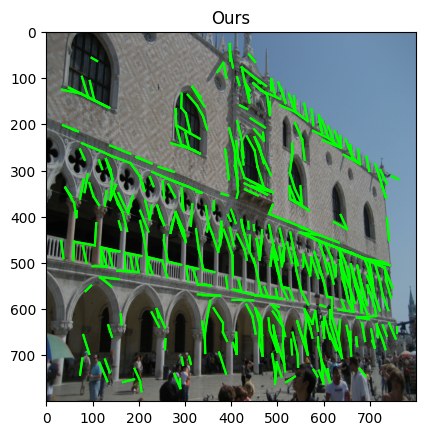

In [1113]:
# plt.imshow(np_gs_image)
plt.title('Ours')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = lines[res.nonzero()] # np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    # x1, y1 = x1s[i], y1s[i]
    # x2, y2 = x2s[i], y2s[i]
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='lime')#, linewidth=0.5)
# plt.scatter(*junctions.T[::-1], c='cyan', s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c='lime', s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c='lime', s=5)
# plt.legend()
plt.show()

points.mean() 0.26920003
direction 0.9342881110041339
inlier_ratio 1.0
angles.std() 0.2557897
angles.mean() 1.6112869
True False True False


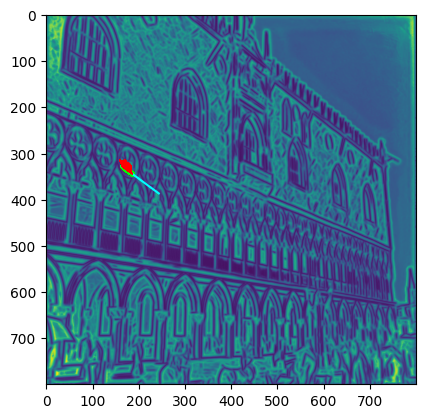

points.mean() 0.3388662
direction 0.6435011087908844
inlier_ratio 1.0
angles.std() 0.029804958
angles.mean() 0.17807607
True True True False


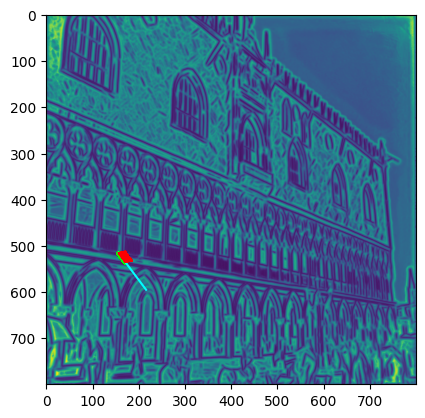

points.mean() 0.1851468
direction 0.2606023917465112
inlier_ratio 1.0
angles.std() 0.13400061
angles.mean() 1.420374
True False True False


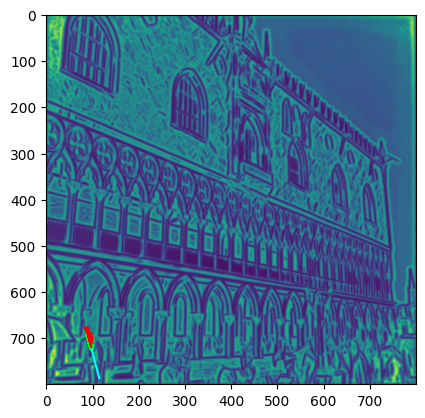

points.mean() 0.17343107
direction 0.6037493333958248
inlier_ratio 1.0
angles.std() 0.21114814
angles.mean() 1.4030076
True False True False


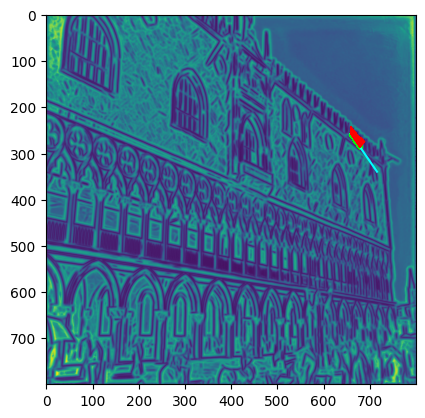

points.mean() 0.22584087
direction 0.0996686524909145
inlier_ratio 1.0
angles.std() 0.09447112
angles.mean() 1.5249188
True False True False


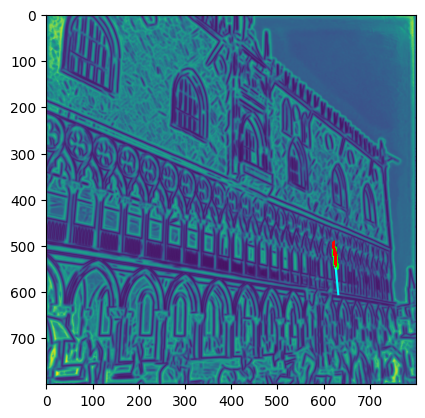

points.mean() 0.1912506
direction 0.5561662301192412
inlier_ratio 1.0
angles.std() 0.06413903
angles.mean() 1.4938393
True True True False


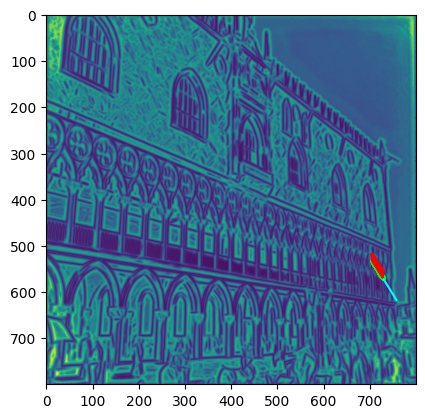

CPU times: user 39.8 s, sys: 7.34 s, total: 47.1 s
Wall time: 46.2 s


In [843]:
%%time

# res = np.zeros((len(kpx), len(kpx)))
res = np.zeros(len(lines))

df = torch.Tensor(npdf / npdf.max())
df = (npdf / npdf.max())
# df = torch.Tensor(npdf)

points = junctions.copy()

nplines = lines.numpy()

# res = is_there_a_line_between(lines, df, 300, df_thresh=0.9, a_diff_thresh=0.383, inlier_thresh=0.7)
for i in range(len(nplines)):
    x1, x2 = nplines[i, 0]
    y1, y2 = nplines[i, 1]
    res[i] = is_there_a_line_between(
        x1, y1, x2, y2, df, 
        n_samples=300, 
        df_thresh=0.7, 
        inlier_thresh=0.7, 
        dist_thresh=100, 
        a_diff_thresh=np.pi/60,
        a_std_thresh=np.pi/40,
        # r_ratio = 0.3,
        r_radius = 5,
        check_sample=((i % 1000)==0)
    )

In [789]:
def align_with_grad_angle(angle, img):
    """ Starting from an angle in [0, pi], find the sign of the angle based on
        the image gradient of the corresponding pixel. """
    # Image gradient
    img_grad_angle = compute_image_grad(img)[3]
    
    # Compute the distance of the image gradient to the angle
    # and angle - pi
    pred_grad = np.mod(angle, np.pi)  # in [0, pi]
    pos_dist = np.minimum(np.abs(img_grad_angle - pred_grad),
                          2 * np.pi - np.abs(img_grad_angle - pred_grad))
    neg_dist = np.minimum(
        np.abs(img_grad_angle - pred_grad + np.pi),
        2 * np.pi - np.abs(img_grad_angle - pred_grad + np.pi))
    
    # Assign the new grad angle to the closest of the two
    is_pos_closest = np.argmin(np.stack([neg_dist, pos_dist],
                                        axis=-1), axis=-1).astype(bool)
    new_grad_angle = np.where(is_pos_closest, pred_grad, pred_grad - np.pi)
    return new_grad_angle, img_grad_angle

def preprocess_angle(angle, img, mask=False):
    """ Convert a grad angle field into a line level angle, using
        the image gradient to get the right orientation. """
    oriented_grad_angle, img_grad_angle = align_with_grad_angle(angle, img)
    oriented_grad_angle = np.mod(oriented_grad_angle - np.pi / 2, 2 * np.pi)
    if mask:
        oriented_grad_angle[0] = -1024
        oriented_grad_angle[:, 0] = -1024
    return oriented_grad_angle.astype(np.float64), img_grad_angle

def compute_image_grad(img, ksize=7):
    blur_img = cv2.GaussianBlur(img, (ksize, ksize), 1).astype(np.float32)
    dx = np.zeros_like(blur_img)
    dy = np.zeros_like(blur_img)
    dx[:, 1:] = (blur_img[:, 1:] - blur_img[:, :-1]) / 2
    dx[1:, 1:] = dx[:-1, 1:] + dx[1:, 1:]
    dy[1:] = (blur_img[1:] - blur_img[:-1]) / 2
    dy[1:, 1:] = dy[1:, :-1] + dy[1:, 1:]
    gradnorm = np.sqrt(dx ** 2 + dy ** 2)
    gradangle = np.arctan2(dy, dx)
    return dx, dy, gradnorm, gradangle

def filter_outlier_lines(
    img, lines, df, angle, mode='inlier_thresh', use_grad=False,
    inlier_thresh=0.5, df_thresh=1.5, ang_thresh=np.pi / 6, n_samples=50):
    """ Filter out outlier lines either by comparing the average DF and
        line level values to a threshold or by counting the number of inliers
        across the line. It can also optionally use the image gradient.
    Args:
        img: the original image.
        lines: a (N, 2, 2) np array.
        df: np array with the distance field.
        angle: np array with the grad angle field.
        mode: 'mean' or 'inlier_thresh'.
        use_grad: True to use the image gradient instead of line_level.
        inlier_thresh: ratio of inliers to get accepted.
        df_thresh, ang_thresh: thresholds to determine a valid value.
        n_samples: number of points sampled along each line.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    # Get the right orientation of the line_level and the lines orientation
    oriented_line_level, img_grad_angle = preprocess_angle(angle, img)
    orientations = get_line_orientation(lines, oriented_line_level)

    # Get the sample positions
    t = np.linspace(0, 1, n_samples)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the DF and angle map
    df_samples = bilinear_interpolate_numpy(df, samples[:, 1], samples[:, 0])
    df_samples = df_samples.reshape(-1, n_samples)
    if use_grad:
        oriented_line_level = np.mod(img_grad_angle - np.pi / 2, 2 * np.pi)
    ang_samples = nn_interpolate_numpy(oriented_line_level, samples[:, 1],
                                       samples[:, 0]).reshape(-1, n_samples)

    # Check the average value or number of inliers
    if mode == 'mean':
        df_check = np.mean(df_samples, axis=1) < df_thresh
        ang_avg = np.arctan2(np.sin(ang_samples).sum(axis=1),
                             np.cos(ang_samples).sum(axis=1))
        ang_diff = np.minimum(np.abs(ang_avg - orientations),
                              2 * np.pi - np.abs(ang_avg - orientations))
        ang_check = ang_diff < ang_thresh
        valid = df_check & ang_check
    elif mode == 'inlier_thresh':
        df_check = df_samples < df_thresh
        ang_diff = np.minimum(
            np.abs(ang_samples - orientations[:, None]),
            2 * np.pi - np.abs(ang_samples - orientations[:, None]))
        ang_check = ang_diff < ang_thresh
        valid = (df_check & ang_check).mean(axis=1) > inlier_thresh
    else:
        raise ValueError("Unknown filtering mode: " + mode)

    return lines[valid], valid

def sample_along_line(lines, img, n_samples=10, mode='mean'):
    """ Sample a fixed number of points along each line and interpolate
        an img at these points, and finally aggregate the values. """
    # Get the sample positions
    t = np.linspace(0, 1, 10)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the img at the samples and aggregate the values
    if mode == 'mean':
        # Average
        val = bilinear_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.mean(val.reshape(-1, n_samples), axis=-1)
    elif mode == 'angle':
        # Average of angles
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)
        val = np.arctan2(np.sin(val).sum(axis=-1), np.cos(val).sum(axis=-1))
    elif mode == 'median':
        # Median
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.median(val.reshape(-1, n_samples), axis=-1)
    else:
        # No aggregation
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)

    return val

def nn_interpolate_numpy(img, x, y):
    xi = np.clip(np.round(x).astype(int), 0, img.shape[1] - 1)
    yi = np.clip(np.round(y).astype(int), 0, img.shape[0] - 1)
    return img[yi, xi]


def bilinear_interpolate_numpy(im, x, y):
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1] - 1)
    x1 = np.clip(x1, 0, im.shape[1] - 1)
    y0 = np.clip(y0, 0, im.shape[0] - 1)
    y1 = np.clip(y1, 0, im.shape[0] - 1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return (Ia.T * wa).T + (Ib.T * wb).T + (Ic.T * wc).T + (Id.T * wd).T

def detect_afm_lines(
    img, df, line_level, filtering='normal',
    merge=False, grad_thresh=3, grad_nfa=True):
    """ Detect lines from the line distance and angle field.
        Offer the possibility to ignore line in high DF values,
        and to merge close-by lines. """
    gradnorm = np.maximum(5 - df, 0).astype(np.float64)
    angle = line_level.astype(np.float64) - np.pi / 2
    angle = preprocess_angle(angle, img, mask=True)[0]
    angle[gradnorm < grad_thresh] = -1024
    
    lines = lsd(
        img.astype(np.float64), scale=1., gradnorm=gradnorm,
        gradangle=angle, grad_nfa=grad_nfa)[:, :4].reshape(-1, 2, 2)

    # Optionally filter out lines based on the DF and line_level
    if filtering:
        if filtering == 'strict':
            df_thresh, ang_thresh = 1., np.pi / 12
        else:
            df_thresh, ang_thresh = 1.5, np.pi / 9
        angle = line_level - np.pi / 2
        lines = filter_outlier_lines(
            img, lines[:, :, [1, 0]], df, angle, mode='inlier_thresh',
            use_grad=False, inlier_thresh=0.5, df_thresh=df_thresh,
            ang_thresh=ang_thresh)[0][:, :, [1, 0]]

    # Merge close-by lines together
    if merge:
        lines = merge_lines(lines, thresh=4,
                            overlap_thresh=0).astype(np.float32)
    return lines

In [804]:
%%time

dlsd_lines = detect_afm_lines(gs_image.squeeze().numpy() * 255, npdf, npaf)
dlsd_lines.shape

CPU times: user 282 ms, sys: 50.9 ms, total: 333 ms
Wall time: 334 ms


(981, 2, 2)

In [799]:
dlsd_lines[:, :, 0]

array([[390.9002  , 389.0436  ],
       [522.02356 , 521.6438  ],
       [442.5816  , 442.50443 ],
       ...,
       [ 61.155087,  59.555782],
       [336.59763 , 339.8152  ],
       [500.07614 , 504.56638 ]], dtype=float32)

In [727]:
# plt.imshow(np.triu(res))
# plt.imshow(res)
res.shape, res.sum()

((23176,), 4.0)

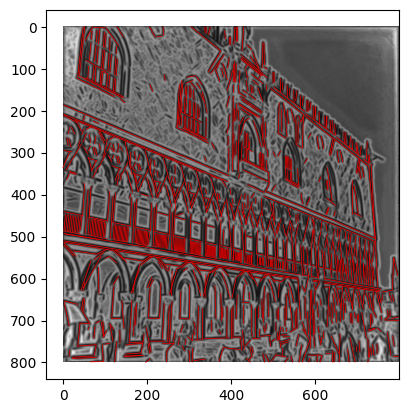

In [803]:
plt.imshow(npdf, cmap='gray')
line_segs = dlsd_lines.copy() #lines[res.nonzero()] # np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, :, 1]
valid_ys = line_segs[:, :, 0]
for i in range(len(line_segs)):
    # x1, y1 = x1s[i], y1s[i]
    # x2, y2 = x2s[i], y2s[i]
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='r', linewidth=0.5)
# plt.scatter(*junctions.T[::-1], c='cyan', s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c='lime', s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c='lime', s=5)
# plt.legend()
plt.show()

IndexError: index 620 is out of bounds for axis 0 with size 620

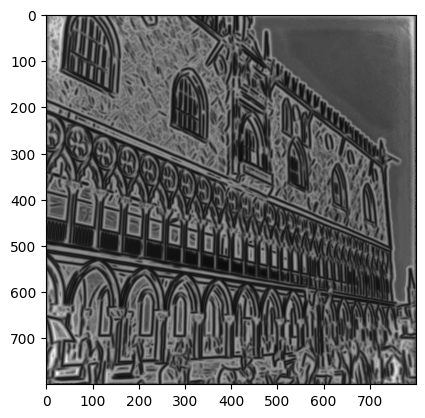

In [689]:
plt.imshow(npdf, cmap='gray')
line_segs = lines[res] # np.triu(res).nonzero()
# line_segs = np.triu(res).nonzero()
# x1s, y1s = points[line_segs[0]].T
# x2s, y2s = points[line_segs[1]].T
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs[0])):
    x1, y1 = x1s[i], y1s[i]
    x2, y2 = x2s[i], y2s[i]
    # x1, x2 = valid_xs[i]
    # y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c='r', linewidth=1)
plt.scatter(*junctions.T[::-1], c='cyan', s=1)
plt.scatter(y1s, x1s, c='lime', s=5)
plt.scatter(y2s, x2s, c='lime', s=5)
# plt.legend()
plt.show()

In [436]:
points[line_segs[1]].T

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [255]:
points.T

array([[ 67,  70,  70, 117, 125, 135, 138, 142, 143, 153, 153, 156, 157,
        157, 173, 183, 185, 196, 196, 207, 210, 212, 215, 221, 221, 222,
        222, 222, 228, 228, 234, 235, 242, 244, 245, 246, 258, 259, 260,
        260, 266, 266, 268, 272, 273, 274, 276, 276, 277, 277, 277, 278,
        278, 279, 285, 285, 286, 290, 291, 291, 292, 293, 294, 301, 309,
        314, 319, 326, 327, 337, 343, 353, 356, 360, 360, 360, 361, 366,
        366, 366, 376, 377, 384, 385, 387, 395, 396, 396, 397, 398, 400,
        401, 406, 408, 408, 408, 408, 408, 409, 412, 413, 418, 418, 419,
        423, 429, 435, 436, 443, 446, 453, 454, 465, 474, 478, 485, 491,
        498, 500, 503, 522, 526, 529, 535, 543, 546, 547, 549, 551, 553,
        554, 557, 557, 560, 562, 562, 580, 580, 582, 583, 584, 588, 588,
        589, 594, 595, 603, 604, 604, 606, 606, 613, 614, 615, 616, 647,
        648, 655, 656, 662, 662, 663, 671, 672, 675, 681, 684, 710, 711,
        711, 718, 718, 736, 740, 744, 765],
       

In [ ]:
def is_there_a_line_between(lines, df,
    # x1, y1, x2, y2, df, 
                            n_samples=10, df_thresh=0.3, inlier_thresh=0.7, dist_thresh=50, 
                            r_ratio=0.1, a_diff_thresh=np.pi/20, a_std_thresh=np.pi/30):
    # l = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    # if l > dist_thresh:
    #     return False
    # if x1 == x2 and y1 == y2:
    #     return False
    # if x1 > x2:
    #     x1, x2 = x2, x1
    # if y1 > y2:
    #     y1, y2 = y2, y1
    # # df = df / df.max()
    # # xs = np.random.randint(x1, x2 + 1, size=sample_n)
    # # ys = np.random.randint(y1, y2 + 1, size=sample_n)
    # sample_n = max(min(sample_n, (x2 - x1), (y2 - y1)), 1)
    # xint = max((x2 - x1) / (sample_n + 1), 1 / sample_n)
    # yint = max((y2 - y1) / (sample_n + 1), 1 / sample_n)

    # xs = np.round(np.arange(x1, x2 + np.ceil(xint), xint))[:sample_n + 2].astype(int)
    # ys = np.round(np.arange(y1, y2 + np.ceil(yint), yint))[:sample_n + 2].astype(int)

    # xs = xs[:min(len(xs), len(ys))]
    # ys = ys[:min(len(xs), len(ys))]

    # # plt.imshow(npdf)
    # # plt.scatter(xs, ys, c='r')
    # # plt.show()

    # # points = df[xs, ys]

    # r = int(l * r_ratio)
    # # return np.array([df[xs[i]-r:xs[i]+r, ys[i]-r:ys[i]+r] for i in range(len(xs))])
    # # print([df[xs[i]-r:xs[i]+r, ys[i]-r:ys[i]+r].min() for i in range(len(xs))])
    # # print(xs, ys, r)
    # points = np.array([df[max(xs[i]-r, 0):xs[i]+r+1, max(ys[i]-r, 0):ys[i]+r+1].min() for i in range(len(xs))])

    # inlier_ratio = (points < thresh).sum() / len(xs)

    # direction = (np.arctan((y2 - y1) / (x2 - x1 + 1e-10)) + np.pi / 2) % np.pi

    df = df.T
    rows, cols = df.shape
    alpha = torch.linspace(0, 1, n_samples, device=df.device)[None]
    x_coord = 2 * (lines[:, :1, 0] * alpha
                   + lines[:, :1, 1] * (1 - alpha)) / cols - 1
    y_coord = 2 * (lines[:, 1:, 0] * alpha
                   + lines[:, 1:, 1] * (1 - alpha)) / rows - 1
    grid = torch.stack([x_coord, y_coord], dim=-1)[None]
    # grid is of size [1, num_lines, n_samples, 2]
    df_samples = F.grid_sample(df[None, None], grid, mode='bilinear',
                               padding_mode='border')[0, 0]
    df_check = df_samples.mean(dim=1) < df_thresh

    line_len = torch.sqrt(((lines[:, 0] - lines[:, 1]) ** 2).sum(dim=1))
    line_level = torch.Tensor(npaf.T)
    vec_x = ((lines[:, 0, 1] - lines[:, 0, 0]) / line_len).unsqueeze(-1)
    vec_y = ((lines[:, 1, 1] - lines[:, 1, 0]) / line_len).unsqueeze(-1)
    cos_line_level = torch.cos(line_level)[None, None]
    sin_line_level = torch.sin(line_level)[None, None]
    cos_samples = F.grid_sample(cos_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    sin_samples = F.grid_sample(sin_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    ang_check = torch.abs(
        cos_samples * vec_y - sin_samples * vec_x).mean(dim=1) < a_diff_thresh

    # crit1 = points.mean() < thresh
    # crit2 = npaf[xs, ys].std() < a_std_thresh
    # crit3 = inlier_ratio > inlier_thresh
    # crit4 = abs(npaf[xs, ys].mean() - direction) < a_diff_thresh

    # return crit1 & crit2 & crit3 & crit4 & ang_check
    return df_check & ang_check

# is_there_a_line_between(100, 130, 100, 106, torch.Tensor(npdf))